### Stage 2: FitnessGroup clusterization

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering 

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### 1. Data Preprocessing

#### 1.1. Data Loading

In [2]:
FitBit_data = pd.read_csv("FitBit_initial_data.csv")
FitBit_data

,Id,Day,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1503960366,2016-04-12,1985,13162,327.0,1
1,1503960366,2016-04-13,1797,10735,384.0,1
2,1503960366,2016-04-15,1745,9762,412.0,0
3,1503960366,2016-04-16,1863,12669,340.0,1
4,1503960366,2016-04-17,1728,9705,700.0,1
...,...,...,...,...,...,...
408,8792009665,2016-04-30,2896,7174,343.0,0
409,8792009665,2016-05-01,1962,1619,503.0,0
410,8792009665,2016-05-02,2015,1831,415.0,0
411,8792009665,2016-05-03,2297,2421,516.0,0


In [3]:
FitBit_data.describe()

,Id,Calories,Steps,TotalMinutesAsleep,IntensityGroup
count,4.130000e+02,413.000000,413.000000,413.000000,413.000000
mean,5.000979e+09,2397.573850,8541.140436,419.467312,0.375303
std,2.060360e+09,762.886326,4156.926990,118.344679,0.484788
min,1.503960e+09,257.000000,17.000000,58.000000,0.000000
25%,3.977334e+09,1850.000000,5206.000000,361.000000,0.000000
50%,4.702922e+09,2220.000000,8925.000000,433.000000,0.000000
75%,6.962181e+09,2926.000000,11393.000000,490.000000,1.000000
max,8.792010e+09,4900.000000,22770.000000,796.000000,1.000000


In [4]:
x_unscaled = FitBit_data[["Calories", "Steps", "TotalMinutesAsleep"]] # Select features

#### 1.2. Data Scaling

Feature scaling in Machine Learning is a method used to normalize the range of independent variables or features of data. Gradient descent and distance-based algorithms are heavily impacted by the range of features.

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your data
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=x_unscaled.columns)

In [6]:
# Save the scaler in order to use it in external application
joblib.dump(scaler, "scaler_clusterization.joblib")

# How to use it later: load the scaler from the file
loaded_scaler = joblib.load("scaler_clusterization.joblib")

input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the loaded scaler to transform new data
output_data = pd.DataFrame(loaded_scaler.transform(input_data), columns=input_data.columns)
output_data

,Calories,Steps,TotalMinutesAsleep
0,-0.788194,0.5284,-0.300059


### 2. Choosing The Best K

#### 2.1. KMeans

#### The Elbow Method

To perform the elbow method, run several k-means (or another method), increment k with each iteration, and record an objective function, or, the sum of squared error (SSE).


In [7]:
plot_n_clusters = 20 # A list holds the SSE values for each n

sse = []
for k in range(1, plot_n_clusters+1):
        kmeans = KMeans(
            n_clusters=k,
            init="k-means++",
            # n_init=10, # to run the k-means clustering algorithms n_init times independently to choose the final model as the one with the lowest SSE
            # max_iter=300, # specify the maximum number of iterations for each single run;
            # tol=1e-04, # controls the tolerance with regard to the changes in the SSE to declare convergence
            random_state=0 # pass an int for reproducible output across multiple function calls
        )
        
        kmeans.fit(x)
        sse.append(kmeans.inertia_)

Find in the following plot, the elbow, which provides a good choice for number of clusters in this dataset.

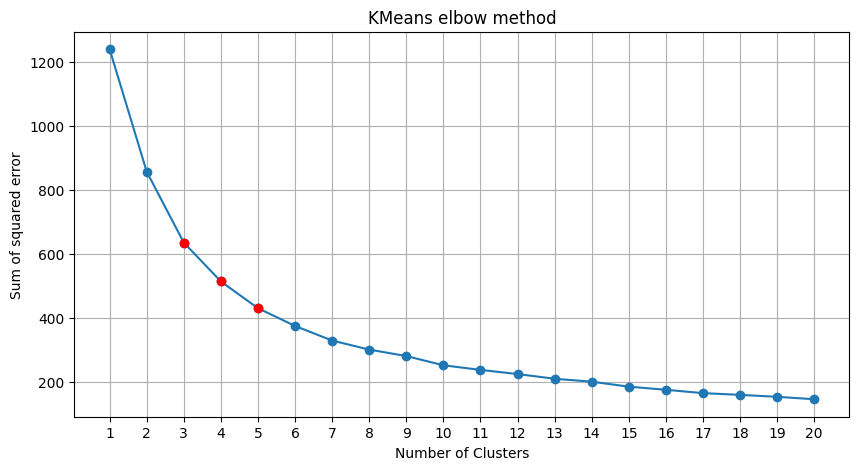

Suggested number of clusters (KMeans, the elbow method): 3, 4 or 5


In [8]:
plt.figure(figsize=(10,5))
plt.plot(range(1, plot_n_clusters+1), sse, "o-")
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.title("KMeans elbow method")
plt.grid()

plt.plot([3,4,5], [sse[2],sse[3],sse[4]], "o", c="red")
plt.show()

print("Suggested number of clusters (KMeans, the elbow method): 3, 4 or 5")

In [9]:
from kneed import KneeLocator # In case you’re having trouble choosing the elbow point of the curve, then you could use a Python package, kneed, to identify the elbow point programmatically

kl = KneeLocator(
    range(1, plot_n_clusters+1),
    sse,
    curve="convex",
    direction="decreasing"
)

print("Suggested number of clusters (KMeans, the elbow method):", kl.elbow)

Suggested number of clusters (KMeans, the elbow method): 5


#### The Silhouette Coefficient

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters

Larger numbers indicate that samples are closer to their clusters than they are to other clusters (means clusters are well apart from each other and clearly distinguished).

In [10]:
silhouette_coefficients = [] # A list holds the silhouette coefficients for each k

for k in range(2, plot_n_clusters+1):
    kmeans = KMeans(
        n_clusters=k, 
        init="k-means++", 
        # batch_size=4096,                
        # n_init=10, 
        # max_iter=300, 
        random_state=0
    )
    
    kmeans.fit(x)
    score = silhouette_score(x, kmeans.labels_)
    silhouette_coefficients.append(score)

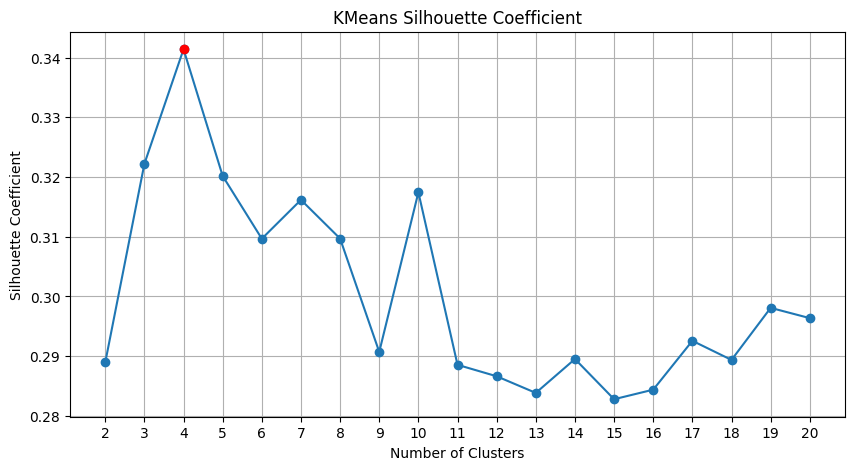

Suggested number of clusters (KMeans, Silhouette Coefficient): 4


In [11]:
plt.figure(figsize=(10,5))
plt.plot(range(2, plot_n_clusters+1), silhouette_coefficients, "o-")
plt.xticks(range(2, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("KMeans Silhouette Coefficient")
plt.grid()

plt.plot([4], [silhouette_coefficients[2]], "o", c="red")
plt.show()

print("Suggested number of clusters (KMeans, Silhouette Coefficient): 4")

#### 2.2. Hierarchical Clustering

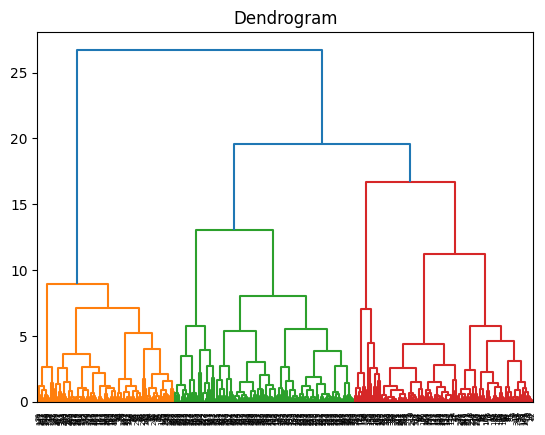

In [12]:
linkage_data = linkage(x, method="ward", metric="euclidean")
dendrogram(linkage_data)
plt.title("Dendrogram")
plt.show()

In [13]:
silhouette_coefficients = [] # A list holds the silhouette coefficients for each k

for k in range(2, plot_n_clusters+1):
    agglomerative_model = AgglomerativeClustering(
        n_clusters=k,
        affinity="euclidean",
        linkage="ward"
    )
    
    agglomerative_model.fit(x)
    score = silhouette_score(x, agglomerative_model.labels_)
    silhouette_coefficients.append(score)

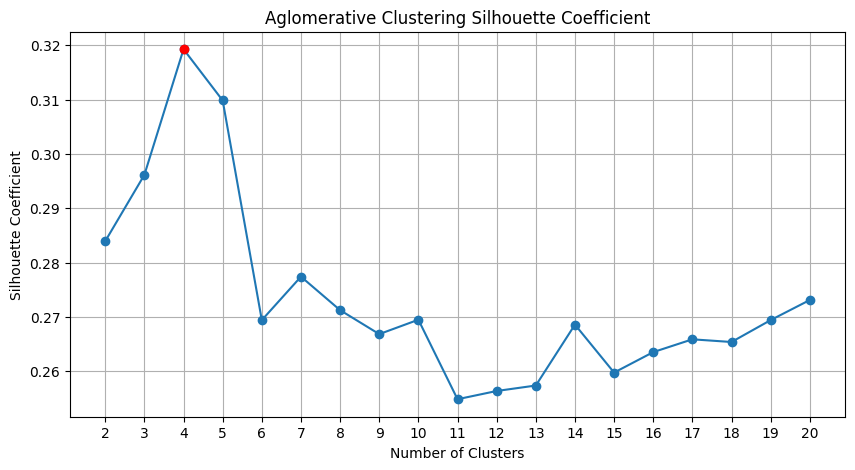

Suggested number of clusters (Aglomerative Clustering, Silhouette Coefficient): 4


In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(2, plot_n_clusters+1), silhouette_coefficients, "o-")
plt.xticks(range(2, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Aglomerative Clustering Silhouette Coefficient")
plt.grid()

plt.plot([4], [silhouette_coefficients[2]], "o", c="red")
plt.show()

print("Suggested number of clusters (Aglomerative Clustering, Silhouette Coefficient): 4")

#### 2.3. Conclusion: The Best k

In [15]:
selected_number_of_clusters = 4

### 3. Testing Clustering Methods

#### 3.0. Clusterization Metrics

#### Davies-Bouldin Index

The Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

#### Calinski-Harabasz Index

If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Here cohesion is estimated based on the distances from the data points in a cluster to its cluster centroid and separation is based on the distance of the cluster centroids from the global centroid.

#### 3.1. Kmeans

In [16]:
kmeans = KMeans(
    n_clusters=selected_number_of_clusters, 
    init="k-means++", 
    random_state=0
)

kmeans_labels = kmeans.fit(x).predict(x)

kmeans_davies_bouldin_score = metrics.davies_bouldin_score(x, kmeans_labels)
kmeans_calinski_harabasz_score = metrics.calinski_harabasz_score(x, kmeans_labels)

print(f"Number of Clusters: {selected_number_of_clusters}")
print(f"Davies-Bouldin Index: {kmeans_davies_bouldin_score}")
print(f"Calinski-Harabasz Index: {kmeans_calinski_harabasz_score}")

Number of Clusters: 4
Davies-Bouldin Index: 1.02089409223912
Calinski-Harabasz Index: 192.29800059004737


#### 3.2. Agglomerative Clustering

In [17]:
agglomerative_model = AgglomerativeClustering(
    n_clusters=selected_number_of_clusters,
    affinity="euclidean",
    linkage="ward"
)

agglomerative_labels = agglomerative_model.fit_predict(x)

agglomerative_davies_bouldin_score = metrics.davies_bouldin_score(x, agglomerative_labels)
agglomerative_calinski_harabasz_score = metrics.calinski_harabasz_score(x, agglomerative_labels)

print(f"Number of Clusters: {selected_number_of_clusters}")
print(f"Davies-Bouldin Index: {agglomerative_davies_bouldin_score}")
print(f"Calinski-Harabasz Index: {agglomerative_calinski_harabasz_score}")

Number of Clusters: 4
Davies-Bouldin Index: 1.073298158927937
Calinski-Harabasz Index: 170.85965778480454


#### 3.3. Gaussian Mixture

In [18]:
gmm = GaussianMixture(
    n_components=selected_number_of_clusters,
    covariance_type="tied", # "tied": all components share the same general covariance matrix.
    init_params="k-means++",
    random_state=0 # pass an int for reproducible output across multiple function calls
)

gmm_labels = gmm.fit(x).predict(x)

gmm_davies_bouldin_score = metrics.davies_bouldin_score(x, gmm_labels)
gmm_calinski_harabasz_score = metrics.calinski_harabasz_score(x, gmm_labels)

print(f"Number of Clusters: {selected_number_of_clusters}")
print(f"Davies-Bouldin Index: {gmm_davies_bouldin_score}")
print(f"Calinski-Harabasz Index: {gmm_calinski_harabasz_score}")

Number of Clusters: 4
Davies-Bouldin Index: 1.0071285339715856
Calinski-Harabasz Index: 164.01601378320234


#### 3.4. DBSCAN

In [19]:
dbscan = DBSCAN(
    eps=3,
    min_samples=2
)

# Use unscaled data, otherwise only 1 cluster is detected
dbscan_labels = dbscan.fit(x_unscaled).labels_

dbscan_davies_bouldin_score = metrics.davies_bouldin_score(x_unscaled, dbscan_labels)
dbscan_calinski_harabasz_score = metrics.calinski_harabasz_score(x_unscaled, dbscan_labels)

print(f"Number of Clusters: {len(np.unique(dbscan_labels))}")
print(f"Davies-Bouldin Index: {dbscan_davies_bouldin_score}")
print(f"Calinski-Harabasz Index: {dbscan_calinski_harabasz_score}")

Number of Clusters: 4
Davies-Bouldin Index: 1.797727279401569
Calinski-Harabasz Index: 2.0731640149221726


### 4. Choosing The Best Model (KMeans)

In [20]:
clustering_index = pd.DataFrame({
    "KMeans": [kmeans_davies_bouldin_score, kmeans_calinski_harabasz_score],
    "Agglomerative Clustering": [agglomerative_davies_bouldin_score, agglomerative_calinski_harabasz_score],
    "Gaussian Mixture": [gmm_davies_bouldin_score, gmm_calinski_harabasz_score],
    "DBSCAN": [dbscan_davies_bouldin_score, dbscan_calinski_harabasz_score],

})

clustering_index.index = ["Davies-Bouldin Index (min is better)","Calinski-Harabasz Index (max is better)"]
clustering_index

,KMeans,Agglomerative Clustering,Gaussian Mixture,DBSCAN
Davies-Bouldin Index (min is better),1.020894,1.073298,1.007129,1.797727
Calinski-Harabasz Index (max is better),192.298001,170.859658,164.016014,2.073164


### 5. Merging Datasets

In [21]:
FitnessGroup = pd.DataFrame(
    kmeans_labels,
    columns=["FitnessGroup"]
)

FitBit_clustered_data = pd.concat(
    [FitBit_data, FitnessGroup], axis=1
)

FitBit_clustered_data

,Id,Day,Calories,Steps,TotalMinutesAsleep,IntensityGroup,FitnessGroup
0,1503960366,2016-04-12,1985,13162,327.0,1,3
1,1503960366,2016-04-13,1797,10735,384.0,1,3
2,1503960366,2016-04-15,1745,9762,412.0,0,3
3,1503960366,2016-04-16,1863,12669,340.0,1,3
4,1503960366,2016-04-17,1728,9705,700.0,1,2
...,...,...,...,...,...,...,...
408,8792009665,2016-04-30,2896,7174,343.0,0,1
409,8792009665,2016-05-01,1962,1619,503.0,0,2
410,8792009665,2016-05-02,2015,1831,415.0,0,2
411,8792009665,2016-05-03,2297,2421,516.0,0,2


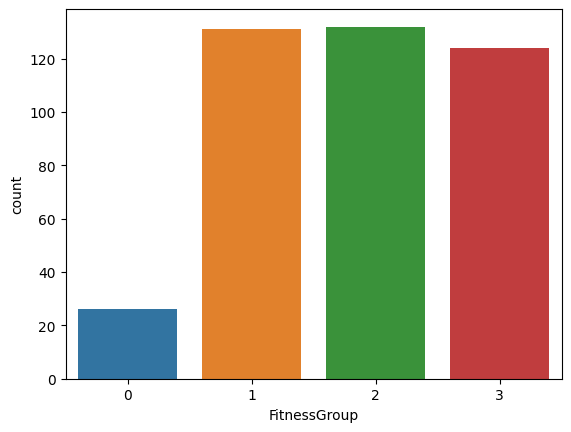

In [22]:
sns.countplot(x=FitBit_clustered_data["FitnessGroup"])
plt.show()

In [23]:
FitBit_clustered_data.to_csv("FitBit_clustered_data.csv", index=False)

### 6. Clusters Distinguished Features

#### 6.1. Cluster Datasets Loading

In [24]:
FitnessGroup0 = FitBit_clustered_data[FitBit_clustered_data["FitnessGroup"] == 0]
FitnessGroup1 = FitBit_clustered_data[FitBit_clustered_data["FitnessGroup"] == 1]
FitnessGroup2 = FitBit_clustered_data[FitBit_clustered_data["FitnessGroup"] == 2]
FitnessGroup3 = FitBit_clustered_data[FitBit_clustered_data["FitnessGroup"] == 3]

#### 6.2. Statistical Info ("Calories", "Steps", "TotalMinutesAsleep" series)

In [25]:
upper_level = ["Fitness group 0", "Fitness group 1", "Fitness group 2", "Fitness group 3"]
lower_level = ["Calories", "Steps", "TotalMinutesAsleep"]

FitnessGroup_0_Info = FitnessGroup0.describe()[["Calories", "Steps", "TotalMinutesAsleep"]]
FitnessGroup_1_Info = FitnessGroup1.describe()[["Calories", "Steps", "TotalMinutesAsleep"]]
FitnessGroup_2_Info = FitnessGroup2.describe()[["Calories", "Steps", "TotalMinutesAsleep"]]
FitnessGroup_3_Info = FitnessGroup3.describe()[["Calories", "Steps", "TotalMinutesAsleep"]]

FitnessGroup_0_Info.columns = pd.MultiIndex.from_product([[upper_level[0]], lower_level])
FitnessGroup_1_Info.columns = pd.MultiIndex.from_product([[upper_level[1]], lower_level])
FitnessGroup_2_Info.columns = pd.MultiIndex.from_product([[upper_level[2]], lower_level])
FitnessGroup_3_Info.columns = pd.MultiIndex.from_product([[upper_level[3]], lower_level])

FitnessGroup_Info = pd.concat(
    [FitnessGroup_0_Info,FitnessGroup_1_Info,FitnessGroup_2_Info,FitnessGroup_3_Info], 
    axis=1
)

FitnessGroup_Info = FitnessGroup_Info.round(2)
FitnessGroup_Info

Fitness group 0                              Fitness group 1            \
             Calories     Steps TotalMinutesAsleep        Calories     Steps   
count           26.00     26.00              26.00          131.00    131.00   
mean          2570.27   7569.69             125.96         3272.06  10412.10   
std            627.31   4811.91              64.29          516.47   3153.28   
min           1554.00   1675.00              58.00         2499.00   4496.00   
25%           2106.00   3834.00              77.50         2899.00   8371.00   
50%           2492.00   6524.50             110.50         3083.00  10074.00   
75%           3010.75  10811.25             148.25         3649.00  12369.00   
max           3846.00  19769.00             296.00         4900.00  22770.00   

                         Fitness group 2                               \
      TotalMinutesAsleep        Calories     Steps TotalMinutesAsleep   
count             131.00          132.00    132.00             132.00   
mean              435.84         1884.65   4297.57             497.89   
std                66.18          459.15   2209.16              90.20   
min               293.00          257.00     17.00             302.00   
25%               388.00         1622.25   2742.25             439.00   
50%               432.00         1879.50   4096.50             497.00   
75%               478.50         2180.25   5536.75             531.00   
max               611.00         2908.00  10060.00             796.00   

      Fitness group 3                               
             Calories     Steps TotalMinutesAsleep  
count          124.00    124.00             124.00  
mean          1983.52  11285.60             380.23  
std            295.08   2573.24              78.30  
min           1364.00   6093.00             213.00  
25%           1785.25   9767.25             326.50  
50%           2012.50  10881.50             383.00  
75%           2195.50  12789.50             442.00  
max           2629.00  20031.00             535.00

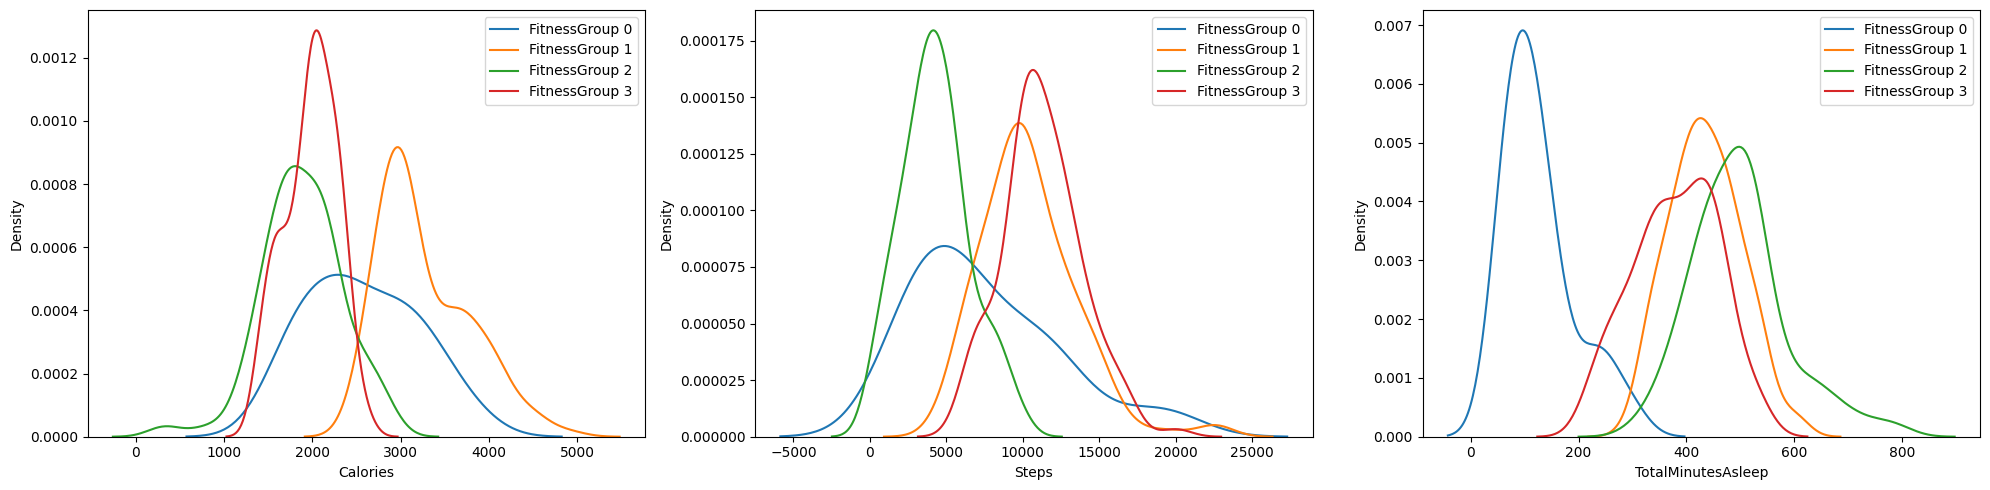

In [26]:
plt.figure(figsize=(20,5))
for (column,i) in zip(["Calories","Steps","TotalMinutesAsleep"],range(3)):
    plt.subplot(1,3,i+1)
    sns.kdeplot(data=FitnessGroup0, x=column)
    sns.kdeplot(data=FitnessGroup1, x=column)
    sns.kdeplot(data=FitnessGroup2, x=column)
    sns.kdeplot(data=FitnessGroup3, x=column)
    plt.legend(["FitnessGroup 0","FitnessGroup 1","FitnessGroup 2","FitnessGroup 3"])

plt.tight_layout()
plt.show()

#### 6.3. Piecharts ("IntensityGroup" series)

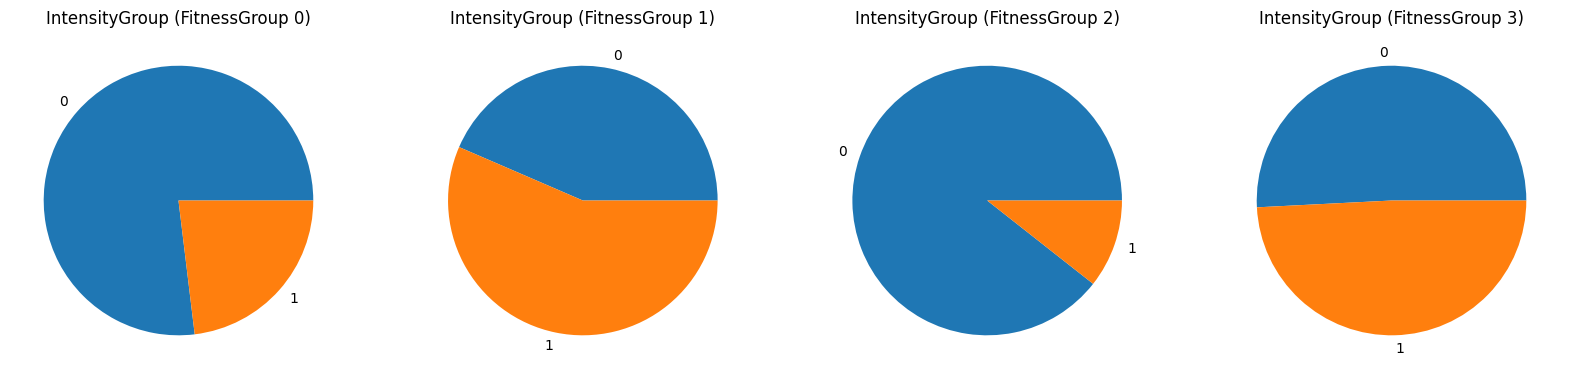

In [27]:
plt.figure(figsize=(20,5))
for (dataset,i) in zip([FitnessGroup0,FitnessGroup1,FitnessGroup2,FitnessGroup3],range(4)):
    plt.subplot(1,4,i+1)

    plt.pie(
        x=np.histogram(dataset["IntensityGroup"],bins=2)[0],
        labels=["0","1"]
    )   
    plt.title(f"IntensityGroup (FitnessGroup {i})")

plt.show()